In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches

In [2]:
import os
os.chdir('./data/fishspots/')

In [7]:
import os, glob
import tifffile as tiff
import numpy as np

src_dir = './train/image'           
dst_dir = './train/image_scaled'   
os.makedirs(dst_dir, exist_ok=True)

for fp in glob.glob(os.path.join(src_dir, '*.tif')):
    img = tiff.imread(fp).astype(np.float32)
    mi, ma = img.min(), img.max()
    if ma > mi:
        img = (img - mi) / (ma - mi)
    else:
        img = np.zeros_like(img, dtype=np.float32)
    tiff.imwrite(os.path.join(dst_dir, os.path.basename(fp)), img)

image size = (512, 512)


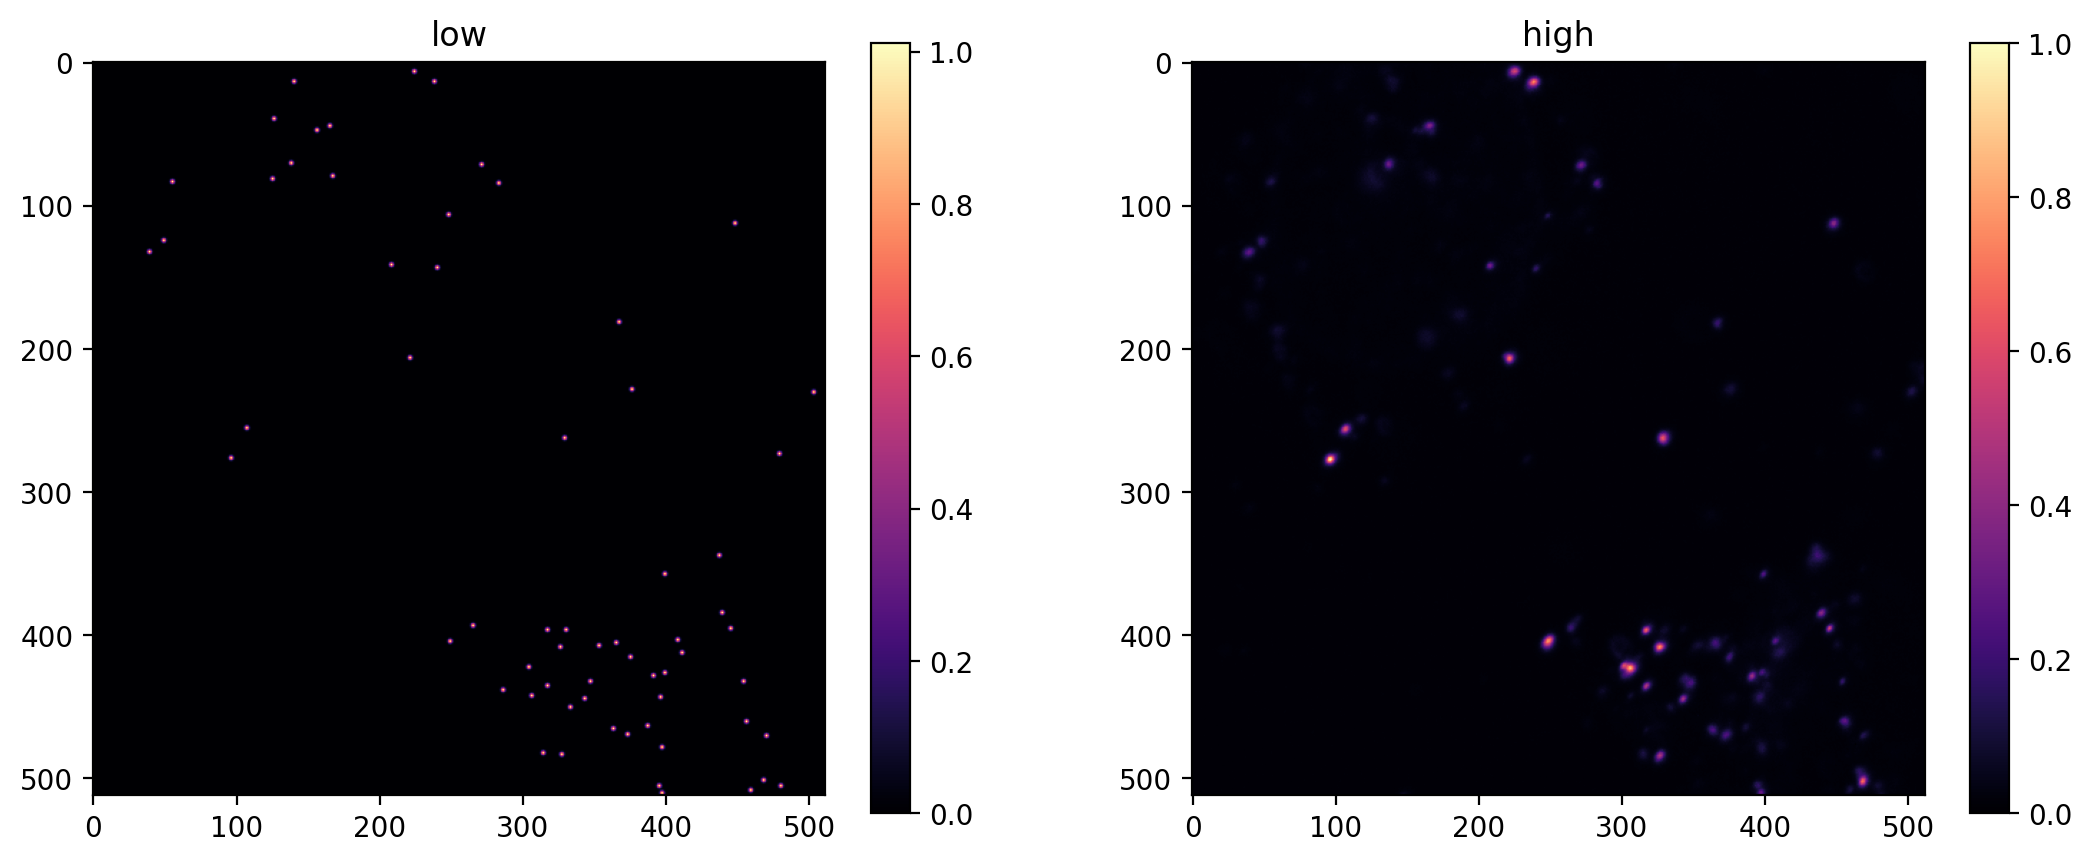

In [8]:
y = imread('./train/image_scaled/ExSeq_100.tif')
x = imread('./train/labels/ExSeq_100.tif')
print('image size =', x.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap  ="magma")
plt.colorbar()
plt.title("low")
plt.subplot(1,2,2)
plt.imshow(y, cmap  ="magma")
plt.colorbar()
plt.title("high");

In [10]:
raw_data = RawData.from_folder (
    basepath    = './train/',
    source_dirs = ['image_scaled'],
    target_dir  = 'labels',
    axes        = 'YX',
)

In [12]:
import numpy as np
from scipy.ndimage import uniform_filter
from csbdeep.data import create_patches

def label_based_filter(datas, patch_size, *, min_fg=500):
    lbl = datas[0] > 0                            
    wnd = (uniform_filter(lbl.astype(np.float32),
                          size=patch_size, mode='constant')
           * np.prod(patch_size))
    return wnd >= min_fg      
    
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (256,256),
    patch_filter        = lambda d, p: label_based_filter(d, p, min_fg=0),
    n_patches_per_image = 2,
    save_file           = 'data/my_training_data.npz',
)

 3616 raw images x    1 transformations   =  3616 images
 3616 images     x    2 patches per image =  7232 patches in total
Input data:
./train/: target='labels', sources=['image_scaled'], axes='YX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
256 x 256


100%|████████████████████████████████████████| 3616/3616 [02:29<00:00, 24.18it/s]


Saving data to data/my_training_data.npz.


In [13]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

2025-05-07 08:51:36.288705: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 08:51:36.291370: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 08:51:36.331719: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 08:51:36.332629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 08:51:37.943029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [14]:
import numpy as np

data = np.load('data/my_training_data.npz')
X_train, Y_train = data['X'], data['Y']
axes = data['axes'].item()   # axes 通常保存在 numpy object 数组里

def percentile_norm(arr, low=1, high=99.9):
    lo, hi = np.percentile(arr, [low, high])
    arr = np.clip(arr, lo, hi)
    return (arr - lo) / (hi - lo + 1e-12)

X_train = percentile_norm(X_train)
Y_train = percentile_norm(Y_train)

np.savez_compressed('data/my_training_data_norm.npz', 
                    X=X_train, Y=Y_train, axes=axes)

print("Normalization complete.")


Normalization complete.


In [15]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/my_training_data_norm.npz', validation_split=0.3, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 5062
number of validation images:	 2170
image size (2D):		 (256, 256)
axes:				 SYXC
channels in / out:		 1 / 1


In [21]:
config = Config(axes, n_channel_in, n_channel_out, unet_kern_size=3, 
                train_batch_size=8, train_steps_per_epoch=20, 
                train_epochs=50)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=50, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=20, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 50,
 'train_steps_per_epoch': 20,
 'train_learning_rate': 0.0004,
 'train_batch_size': 8,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [22]:
model = CARE(config, 'my_model', basedir='models')
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, None, 1)]      0         []                            
                                                                                                  
 down_level_0_no_0 (Conv2D)  (None, None, None, 32)       320       ['input[0][0]']               
                                                                                                  
 down_level_0_no_1 (Conv2D)  (None, None, None, 32)       9248      ['down_level_0_no_0[0][0]']   
                                                                                                  
 max_0 (MaxPooling2D)        (None, None, None, 32)       0         ['down_level_0_no_1[0][0]']   
                                                                                            

/home/hycai/.conda/envs/csbdeep/lib/python3.8/site-packages/csbdeep/models/base_model.py:149: UserWarning: output path for model already exists, files may be overwritten: /home/hycai/data/fishspots/models/my_model
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


 up_level_1_no_0 (Conv2D)    (None, None, None, 64)       73792     ['concatenate_2[0][0]']       
                                                                                                  
 up_level_1_no_2 (Conv2D)    (None, None, None, 32)       18464     ['up_level_1_no_0[0][0]']     
                                                                                                  
 up_sampling2d_3 (UpSamplin  (None, None, None, 32)       0         ['up_level_1_no_2[0][0]']     
 g2D)                                                                                             
                                                                                                  
 concatenate_3 (Concatenate  (None, None, None, 64)       0         ['up_sampling2d_3[0][0]',     
 )                                                                   'down_level_0_no_1[0][0]']   
                                                                                                  
 up_level_

In [23]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/50
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f01d7bf7e50>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f01d7bf7e50>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_o

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


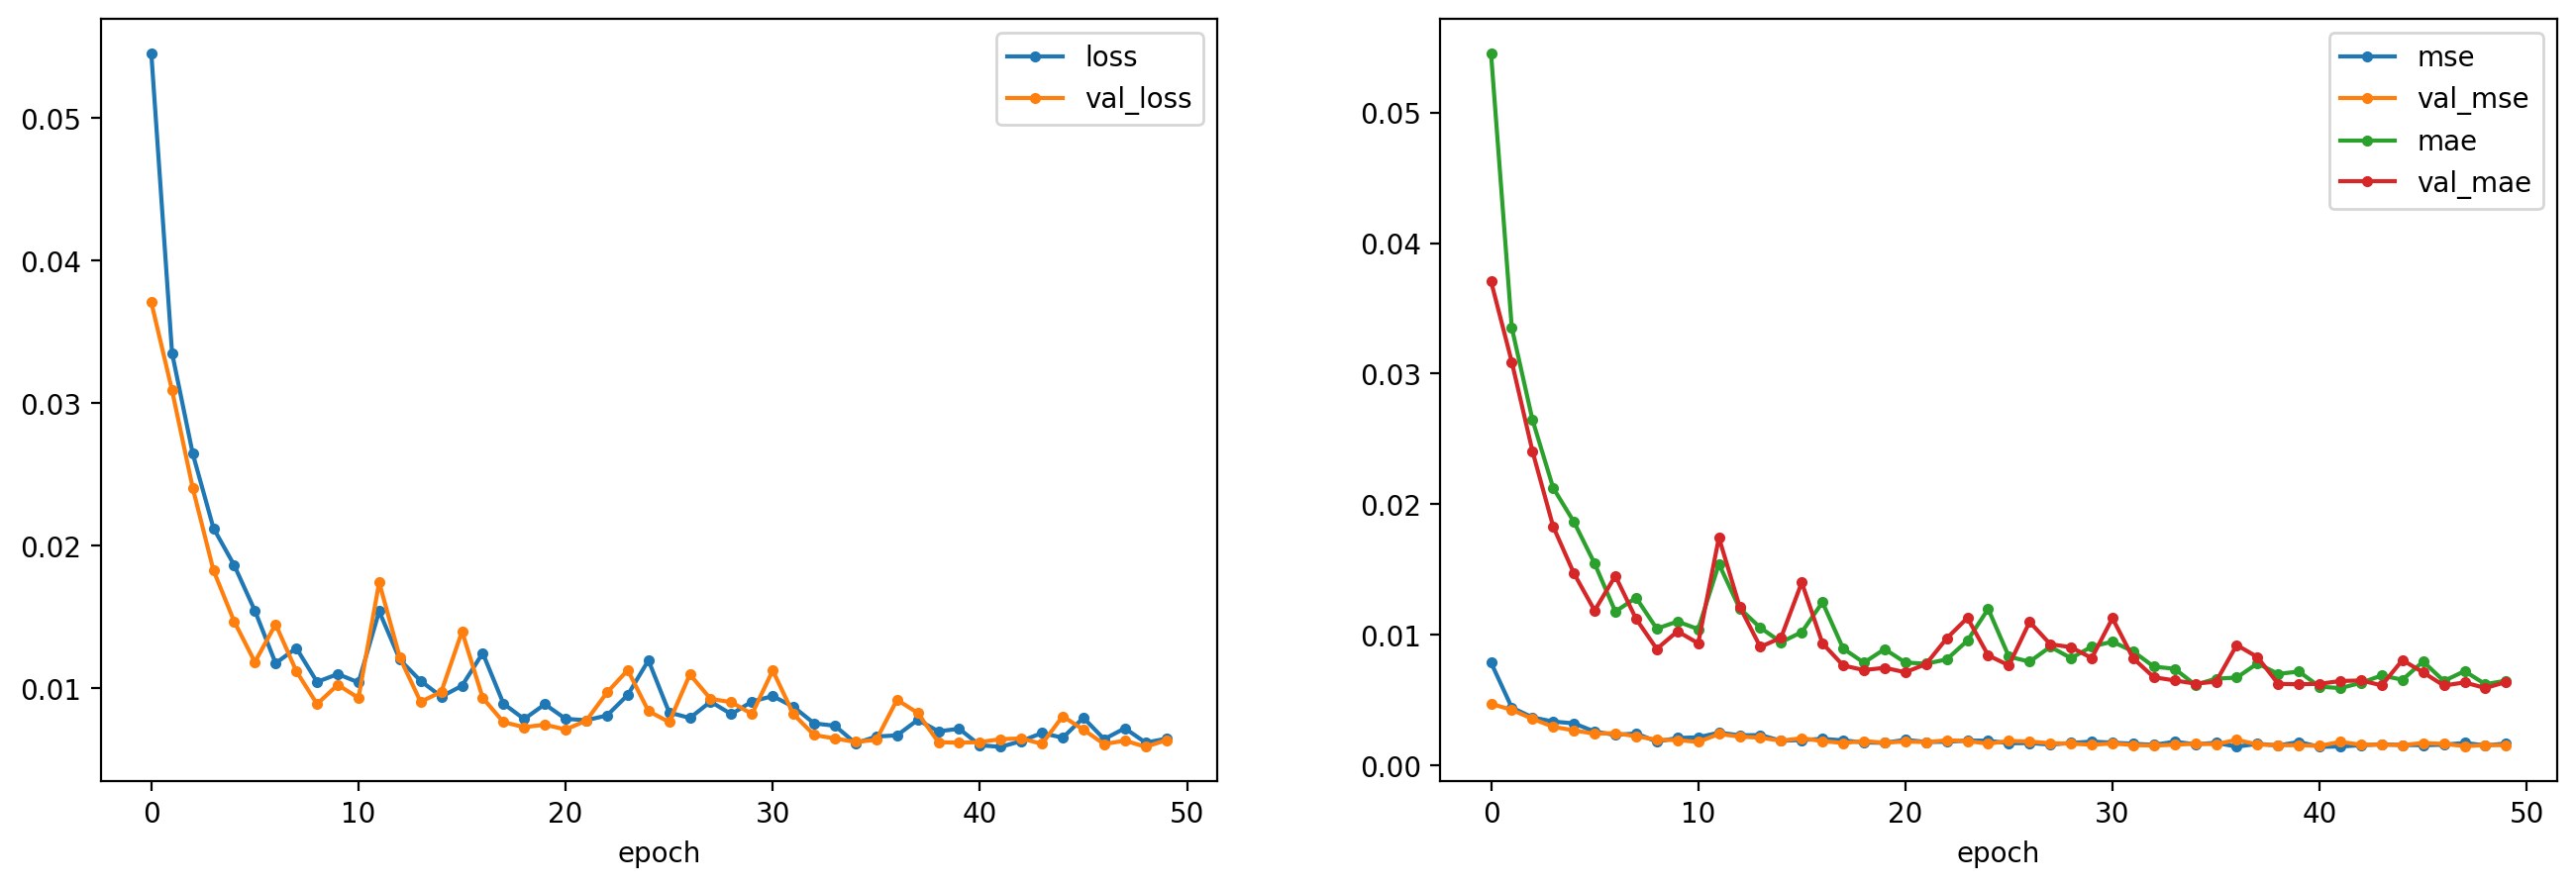

In [25]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

1/1 [==============================] - 0s 186ms/step


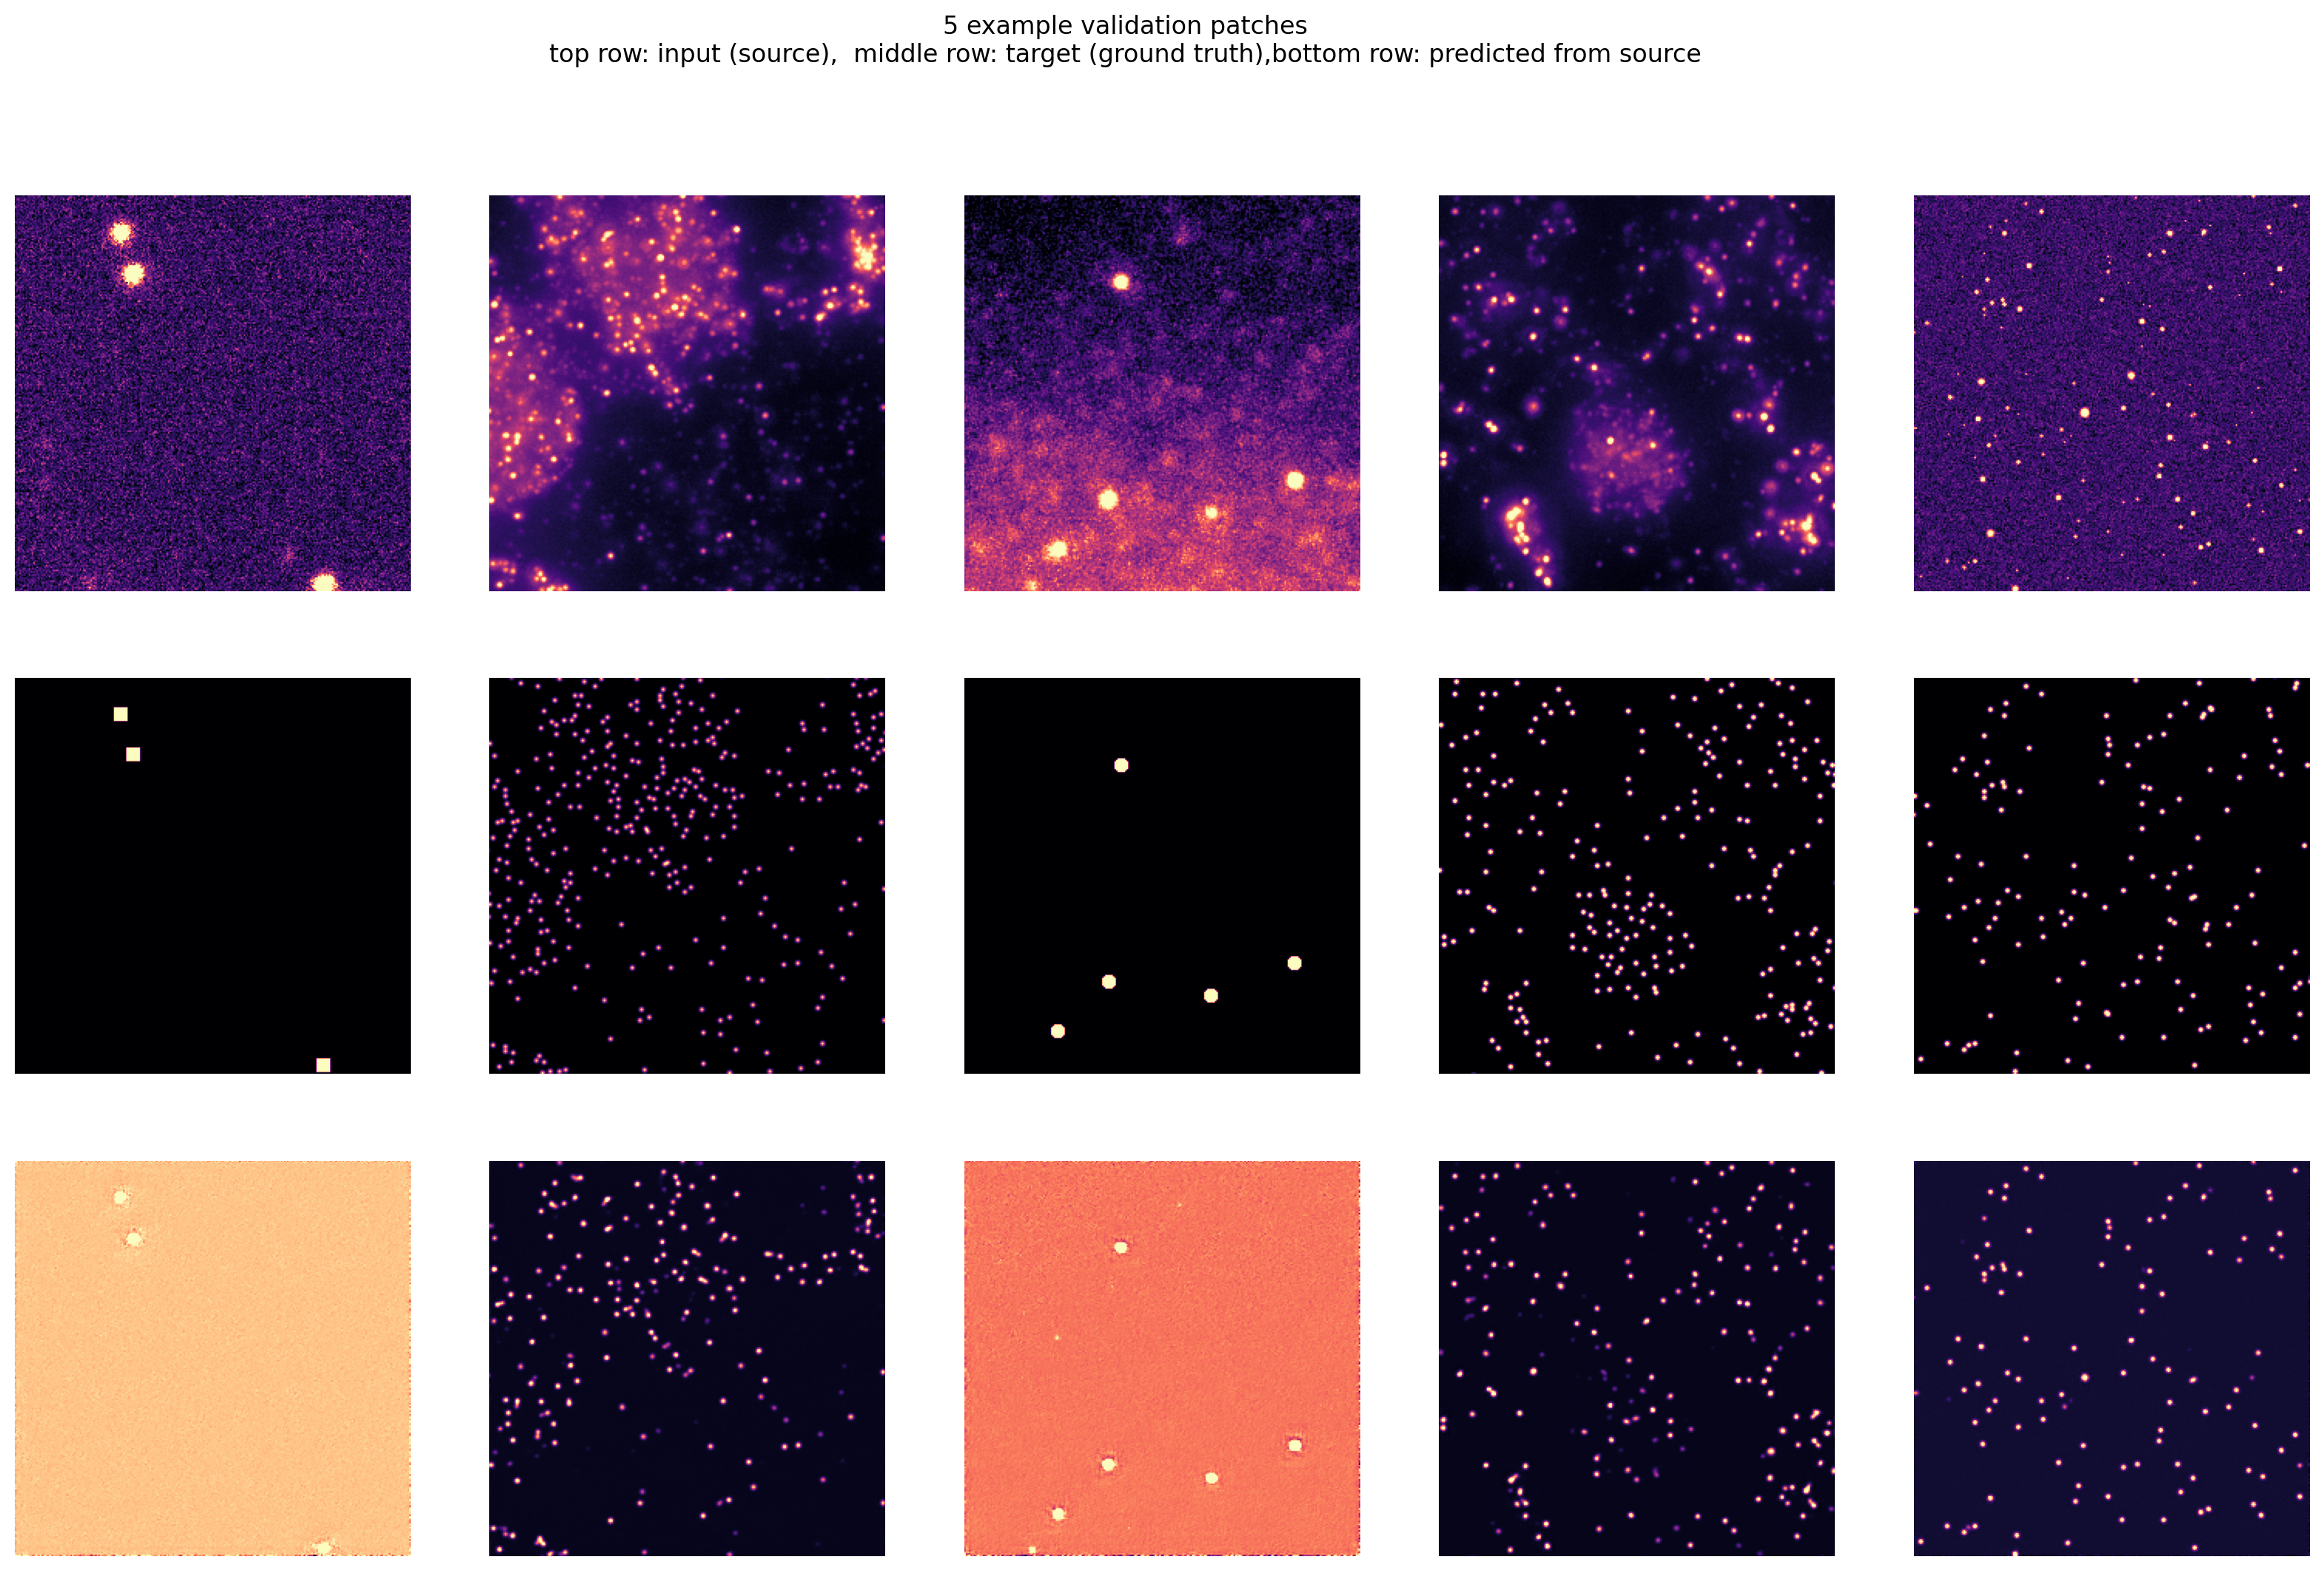

In [26]:
plt.figure(figsize=(20,12))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),'
             'bottom row: predicted from source');

In [29]:
import os, glob
import tifffile as tiff
import numpy as np

src_dir = './test/image'           # 输入目录，改成你的路径
dst_dir = './test/image_scaled'    # 输出目录
os.makedirs(dst_dir, exist_ok=True)

for fp in glob.glob(os.path.join(src_dir, '*.tif')):
    img = tiff.imread(fp).astype(np.float32)
    mi, ma = img.min(), img.max()
    if ma > mi:
        img = (img - mi) / (ma - mi)
    else:
        img = np.zeros_like(img, dtype=np.float32)
    tiff.imwrite(os.path.join(dst_dir, os.path.basename(fp)), img)

In [31]:
test_raw_data = RawData.from_folder (
    basepath    = './test/',
    source_dirs = ['image_scaled'],
    target_dir  = 'labels',
    axes        = 'YX',
)

In [34]:
# 关键思路：用标签图 (Y) 做掩膜，只在有前景的地方抽 patch
# --------------------------------------------------------------
# min_fg = 500：一个 256×256 patch 至少包含 500 个非零像素
# 如需更宽松 / 更严格，只调 min_fg 即可
# --------------------------------------------------------------

import numpy as np
from scipy.ndimage import uniform_filter
from csbdeep.data import create_patches

def label_based_filter(datas, patch_size, *, min_fg=500):
    lbl = datas[0] > 0                                  # datas[0] = 标签图
    # 计算每个中心点对应窗口里的前景像素数
    wnd = (uniform_filter(lbl.astype(np.float32),
                          size=patch_size, mode='constant')
           * np.prod(patch_size))
    return wnd >= min_fg                                # True = 可抽样

X, Y, XY_axes = create_patches(
    raw_data            = test_raw_data,          # [(Y, X) 对列表/生成器]
    patch_size          = (512, 512),
    patch_filter        = lambda d, p: label_based_filter(d, p, min_fg=0),
    n_patches_per_image = 1,                 # 每张图取 4 个 patch
    save_file           = 'data/my_testing_data.npz',
    # verbose             = True,
)

  550 raw images x    1 transformations   =   550 images
  550 images     x    1 patches per image =   550 patches in total
Input data:
./test/: target='labels', sources=['image_scaled'], axes='YX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
512 x 512


100%|██████████████████████████████████████████| 550/550 [00:14<00:00, 37.11it/s]


Saving data to data/my_testing_data.npz.


In [35]:
import numpy as np

# 1. 加载已有数据
data = np.load('data/my_testing_data.npz')
X_train, Y_train = data['X'], data['Y']
axes = data['axes'].item()   # axes 通常保存在 numpy object 数组里

# 2. 百分位剪裁与归一化
def percentile_norm(arr, low=1, high=99.9):
    lo, hi = np.percentile(arr, [low, high])
    arr = np.clip(arr, lo, hi)
    return (arr - lo) / (hi - lo + 1e-12)

X_train = percentile_norm(X_train)
Y_train = percentile_norm(Y_train)

# 3. 保存归一化后的数据
np.savez_compressed('data/my_testing_data_norm.npz', 
                    X=X_train, Y=Y_train, axes=axes)

print("Normalization complete.")


Normalization complete.


In [ ]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/my_testing_data_norm.npz', validation_split=0.3, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

In [14]:
from tifffile import imread
from csbdeep.models import CARE
model = CARE(config=None, name='./data/fishspots/models/my_model/')
x = imread('./data/fishspots/test/image_scaled/MERFISH_155.tif')
restored = model.predict(x, axes='YX')

Loading network weights from 'weights_best.h5'.
1/1 [==============================] - 0s 134ms/step


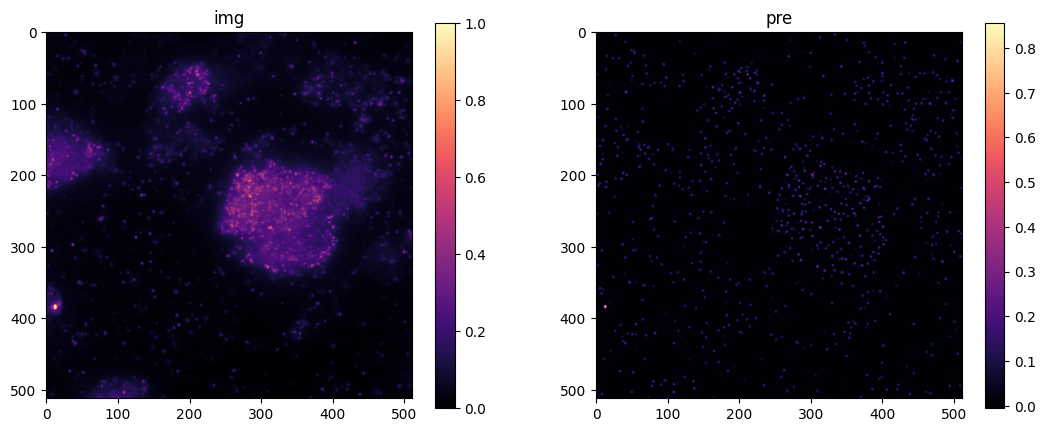

In [15]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap  ="magma")
plt.colorbar()
plt.title("img")
plt.subplot(1,2,2)
plt.imshow(restored, cmap  ="magma")
plt.colorbar()
plt.title("pre");

In [28]:
import os 
import pandas as pd
import numpy as np
from skimage.io import imsave
from skimage.feature import peak_local_max
from skimage.morphology import local_maxima

input_dir = './data/fishspots/test/image_scaled'
output_dir = './data/fishspots/test/pre_img'
csv_dir = './data/fishspots/test/pre_csv'

os.makedirs(output_dir,exist_ok=True)
os.makedirs(csv_dir,exist_ok=True)
files = os.listdir(input_dir)

for file in files:
    x = imread(os.path.join(input_dir, file))
    restored = model.predict(x, axes='YX')
    imsave(os.path.join(output_dir,file),restored)
    mask = local_maxima(restored, connectivity=2)
    mask = mask & (restored > 0.1)
    peaks = np.array(np.where(mask)).T
    df = pd.DataFrame(peaks, columns=[f'axis-{i}' for i in range(mask.ndim)])
    csv_name = file.split('.')[0] + '.pred.csv'
    df.to_csv(os.path.join(csv_dir, csv_name), index=None)

1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_207.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_72.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_302.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_478.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_397.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_72.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_230.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_976.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 54ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_717.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 54ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_58.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_298.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_441.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_107.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_78.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_487.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_209.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_203.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_20.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_388.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_350.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_833.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_393.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_67.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_24.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_281.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_189.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_186.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_537.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_210.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_116.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_609.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_365.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_670.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1138.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_173.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 47ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_394.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_130.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_176.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_276.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_329.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_452.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_481.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 53ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_187.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1173.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_223.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_146.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_260.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_86.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_386.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_434.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_402.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_619.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_888.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_377.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_17.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_405.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_21.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_508.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_207.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_205.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_267.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_450.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 53ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_380.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_503.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_988.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_5.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_152.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_55.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_88.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_303.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 53ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_481.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_340.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_405.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_85.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_245.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_331.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_495.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_170.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_189.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_494.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_520.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_135.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_63.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_629.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_746.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_353.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_147.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_16.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_410.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_872.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_19.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_169.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_364.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_622.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_444.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1010.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_386.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_125.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - ETA: 0s

/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_239.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_366.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_151.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_315.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_291.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_430.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_317.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_871.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_20.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_430.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_523.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_335.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_311.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_198.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_364.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_839.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_513.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_305.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_517.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_641.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_182.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_278.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_367.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_161.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_173.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_544.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_279.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_225.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_50.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_38.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_344.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_252.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_471.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_546.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1176.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_336.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 54ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_53.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1247.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1155.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_130.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - ETA: 0s

/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_568.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_845.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 53ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_221.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_262.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_167.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_464.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_331.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 53ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_877.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1197.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_585.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_240.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_352.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_361.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_641.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_794.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_376.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_286.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_193.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_559.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_532.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_10.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_557.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_333.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_403.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_597.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_330.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 53ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1073.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_153.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_291.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_446.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_99.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_238.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_136.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_128.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_395.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_283.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_360.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_621.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_253.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_655.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_569.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1062.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_5.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_143.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_61.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_309.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 53ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_85.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1233.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_440.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_197.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_87.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_306.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_233.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_15.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1104.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_185.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_941.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_46.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_32.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_574.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_205.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_42.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_380.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_181.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_952.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_248.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_25.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_5.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_372.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_413.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_594.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_292.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_402.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_236.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_317.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_367.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1046.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_577.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_406.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_406.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 47ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_467.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_930.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_521.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_855.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_483.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_157.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_309.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_526.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1106.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_103.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_326.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_376.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_432.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_36.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_338.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1090.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_603.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_55.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_362.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_840.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_413.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_485.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_83.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_615.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_325.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_462.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_286.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_89.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_764.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_54.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_212.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_191.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 53ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_211.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_424.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_607.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1103.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_304.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_329.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_236.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_479.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_496.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_861.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_168.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_101.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_323.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_274.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_246.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_205.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_282.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1234.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_216.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_328.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1149.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_821.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_192.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_386.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_31.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_235.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_43.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_106.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 54ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_321.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_95.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_366.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_402.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - ETA: 0s

/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_745.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_34.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_346.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_281.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_176.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1135.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_401.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_102.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_483.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_543.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_926.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1206.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 53ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_103.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_44.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_533.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_627.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_118.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_486.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_141.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1069.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_81.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_713.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_370.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_403.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_263.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_228.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_216.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_88.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_280.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_226.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_25.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_319.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_104.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 47ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_92.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_204.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_325.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_254.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_259.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_359.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_149.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_408.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_990.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_198.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_777.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1013.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_350.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_162.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_331.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_494.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_310.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_156.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_943.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_9.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_906.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_813.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_665.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_62.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_341.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_835.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_249.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_469.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_418.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_180.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_184.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_372.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_99.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1007.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_367.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_619.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_59.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_325.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_123.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1018.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1097.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_518.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_332.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_71.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_677.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_176.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_416.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_4.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_433.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_520.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_431.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_405.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_405.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_30.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_404.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_255.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 62ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_167.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_153.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_593.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_474.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 54ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_347.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_284.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_250.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_347.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_865.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_386.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1148.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_13.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_327.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_360.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 52ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_466.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_81.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_907.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_295.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_556.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_333.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_992.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 49ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_44.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_191.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_626.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/seqFISH_341.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/ExSeq_47.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_35.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1099.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_1047.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepspot_441.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_257.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_460.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_117.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/MERFISH_410.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 50ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_260.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/simfish_74.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 51ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_272.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/RCA_511.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)


1/1 [==============================] - 0s 48ms/step


/tmp/ipykernel_20256/3004308511.py:19: UserWarning: ./data/fishspots/test/pre_img/deepblink_575.tif is a low contrast image
  imsave(os.path.join(output_dir,file),restored)
